# Unitary cost function gradient descent

Created 03/10/2024

Objectives:
* For a given MPS, apply symmetry action and optimise for full unitary (i.e. not an MPO) at the boundary of the symmetry action. Then extract phase.
* When optimizing for the unitary and overlap costs, it's possible the optimal solution will not be unitary! How to resolve? Unitarity takes priority. But having a large unitarity step size can lead to divergences!
    * Could address this by performing unitarity gradient descent multiple times without overlap gradient descent when near optimum. Has effect of enhancing unitarity cost.

# Package imports

In [2]:
import sys
sys.path.append('../../')

In [3]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import to_npc_array

In [6]:
import re

# Load data

In [7]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [8]:
f_name = DATA_DIR + r"/0_50.h5"

In [9]:
f_name

'../../data/transverse_cluster_200_site_dmrg/0_50.h5'

In [10]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitions

In [11]:
NUM_SITES = 6

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [13]:
npc_I = to_npc_array(np_I)
npc_X = to_npc_array(np_X)
npc_Y = to_npc_array(np_Y)
npc_Z = to_npc_array(np_Z)

In [14]:
symmetry_actions = [
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [15]:
cases = [
    SymmetryActionWithBoundaryUnitaries(test_psi, a*50)
    for a in symmetry_actions
]

In [16]:
for c in cases:
    c.compute_svd_symmetry_action()

In [17]:
test_case = cases[1]

In [18]:
left_environment = test_case.right_projected_symmetry_state

In [19]:
bs = [
    test_case.psi.get_B(i)
    for i in range(
        test_case.right_symmetry_index + 1,
        test_case.right_symmetry_index + 1 + NUM_SITES
    )
]

In [20]:
len(bs)

6

In [21]:
t = left_environment

for i, b in enumerate(bs):
    b_current = b.replace_label('p', f'p{i}')

    t = npc.tensordot(t, b_current, [['vR'], ['vL']])
    t = npc.tensordot(t, b_current.conj(), [['vR*'], ['vL*']])

t = npc.trace(t, 'vR', 'vR*')

In [22]:
t

<npc.Array shape=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2) labels=['p0', 'p0*', 'p1', 'p1*', 'p2', 'p2*', 'p3', 'p3*', 'p4', 'p4*', 'p5', 'p5*']>

In [23]:
leg_labels = [f'p{i}' for i in range(len(bs))]
leg_conj_labels = [f'p{i}*' for i in range(len(bs))]

In [24]:
grouped_t = t.combine_legs([leg_labels, leg_conj_labels])

In [25]:
grouped_t

<npc.Array shape=(64, 64) labels=['(p0.p1.p2.p3.p4.p5)', '(p0*.p1*.p2*.p3*.p4*.p5*)']>

In [26]:
grouped_physical_leg_label = '(p0.p1.p2.p3.p4.p5)'
grouped_physical_leg_conj_label = '(p0*.p1*.p2*.p3*.p4*.p5*)'

## Functions

In [27]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [28]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [29]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [30]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [31]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [32]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [33]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [34]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

In [35]:
def get_random_unitary_operator(mps_tensor, dim):
    # To-do: automate getting dimension
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)
    p_leg_conj = mps_tensor.get_leg(p_leg_label_conj)

    X = scipy.stats.unitary_group.rvs(dim)

    out = npc.Array.from_ndarray(
        X,
        legcharges=[p_leg, p_leg_conj],
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [36]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

### Gradients

In [37]:
def unitarity_gradient(matrix, grouped_physical_leg_label,
                      grouped_physical_leg_conj_label):
    # To-do: Optimise extraction of physical leg labels
    def matrix_multiplication(m1, m2):
        return npc.tensordot(
            m1,
            m2,
            [
                [grouped_physical_leg_label,],
                [grouped_physical_leg_conj_label,]
            ]
        )
    
    t = matrix_multiplication(matrix, matrix.conj())
    score_2 = npc.trace(
        t,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    t = matrix_multiplication(t, matrix)

    score_4 = npc.tensordot(
        t,
        matrix.conj(),
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    return (t - matrix, score_2, score_4)

In [38]:
def overlap_gradient(matrix, reduced_density_matrix,
                     grouped_physical_leg_label,
                     grouped_physical_leg_conj_label,
                     target=1): 

    overlap = npc.tensordot(
        matrix,
        reduced_density_matrix,
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    scale = (overlap - target*overlap/(np.abs(overlap)))
    gradient = scale*reduced_density_matrix.conj()

    return (gradient, overlap)

In [39]:
def update(matrix, reduced_density_matrix, unitarity_scores, overlap_scores,
           target_scores, grouped_physical_leg_label,
           grouped_physical_leg_conj_label, matrix_dim, unitarity_lr,
           overlap_lr, target=1):

    u_grad, u_score_2, u_score_4 = unitarity_gradient(
        matrix, grouped_physical_leg_label, grouped_physical_leg_conj_label
    )

    u_score = u_score_4 - 2*u_score_2 + matrix_dim
    unitarity_scores.append(u_score.real)

    o_gradient, overlap = overlap_gradient(
        matrix,
        reduced_density_matrix,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        target=target
    )

    overlap_scores.append(np.abs(overlap))

    target_score = (
        (overlap_lr/2.0)*(target - np.abs(overlap))**2 +
        (unitarity_lr/4.0)*u_score.real
    )

    target_scores.append(target_score)

    gradient = unitarity_lr*u_grad + overlap_lr*o_gradient
    matrix -= gradient

## Testing

In [40]:
unitarity_scores = list()
overlap_scores = list()
target_scores = list()
matrix_dim = 2**6
target = np.sqrt(2)
unitarity_lr = 0.3
overlap_lr = 0.3

In [41]:
reduced_density_matrix = grouped_t
matrix = get_random_unitary_operator(grouped_t, matrix_dim)

In [42]:
update(
    matrix,
    reduced_density_matrix,
    unitarity_scores,
    overlap_scores,
    target_scores,
    grouped_physical_leg_label,
    grouped_physical_leg_conj_label,
    matrix_dim,
    unitarity_lr=unitarity_lr,
    overlap_lr=overlap_lr,
    target=target
)

In [43]:
unitarity_scores

[2.842170943040401e-14]

In [44]:
overlap_scores

[0.07157832508350342]

In [45]:
target_scores

[0.2704004070617539]

In [46]:
for _ in range(200):
    update(
        matrix,
        reduced_density_matrix,
        unitarity_scores,
        overlap_scores,
        target_scores,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        matrix_dim,
        unitarity_lr=unitarity_lr,
        overlap_lr=overlap_lr,
        target=target
    )

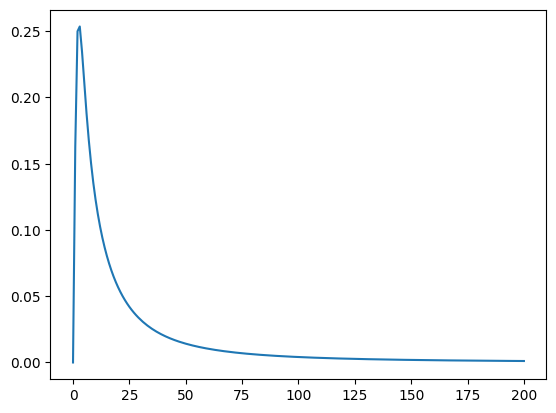

In [47]:
plt.plot(unitarity_scores)

In [48]:
unitarity_scores[-1]

0.001108485960969574

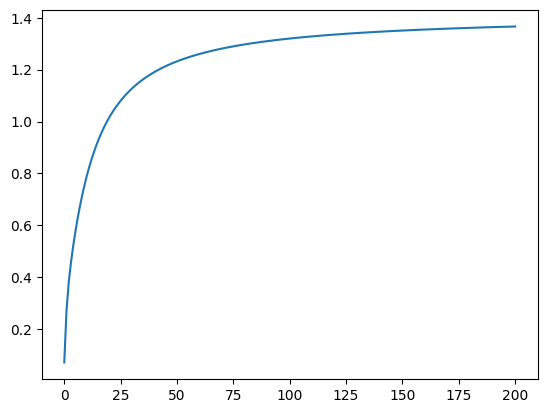

In [49]:
plt.plot(overlap_scores)

In [50]:
overlap_scores[-1]

1.3661073978422924

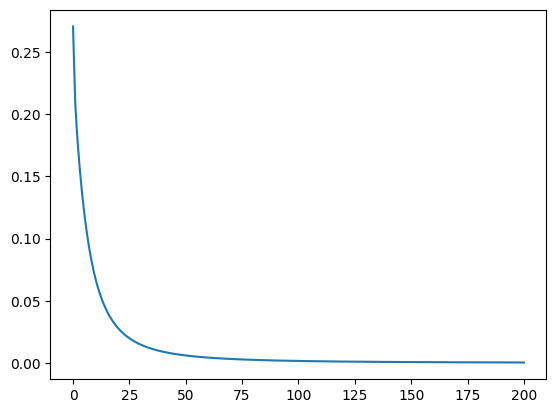

In [51]:
plt.plot(target_scores)

In [52]:
target_scores[-1]

0.0004302669069524176

# Analysis

## Learning rates

In [53]:
learning_rates = [0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

In [54]:
unitarity_scores = list()
overlap_scores = list()
target_scores = list()
matrix_dim = 2**6
target = np.sqrt(2)

num_iterations = 300

In [55]:
reduced_density_matrix = grouped_t
matrix = get_random_unitary_operator(grouped_t, matrix_dim)

In [56]:
for lr in learning_rates:
    unitarity_scores.append(list())
    overlap_scores.append(list())
    target_scores.append(list())

    current_matrix = matrix.copy()

    for _ in range(num_iterations):
        update(
            current_matrix,
            reduced_density_matrix,
            unitarity_scores[-1],
            overlap_scores[-1],
            target_scores[-1],
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label,
            matrix_dim,
            unitarity_lr=lr,
            overlap_lr=lr,
            target=target
        )

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/170727657.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


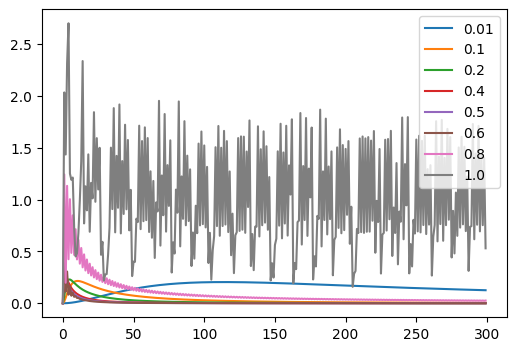

In [57]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores, learning_rates):
    ax.plot(scores, label=label)

ax.legend()

fig.show()

In [58]:
np.array(unitarity_scores)[:,-1]

array([1.25787566e-01, 4.33911605e-03, 1.15711367e-03, 3.03643128e-04,
       1.98041113e-04, 1.40040525e-04, 2.63394579e-02, 5.29590340e-01])

Learning rate of 0.5-0.6 looks good. This agrees with the analytic calculations that a learning rate (for unitarity) of 0.5 is best.

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/3493712344.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


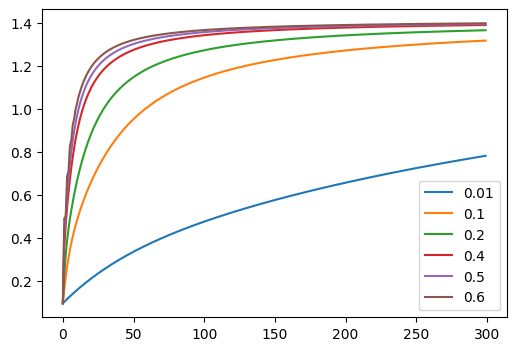

In [59]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(overlap_scores[:-2], learning_rates):
    ax.plot(scores, label=label)

ax.legend()

fig.show()

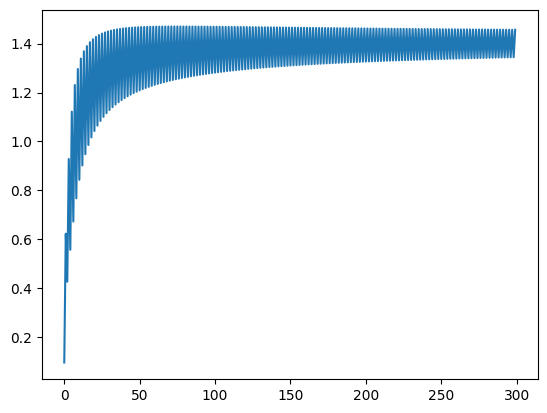

In [60]:
plt.plot(overlap_scores[-2])

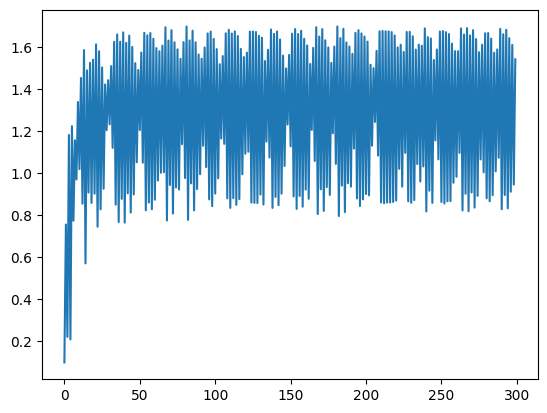

In [61]:
plt.plot(overlap_scores[-1])

In [62]:
np.array(overlap_scores)[:,-1]

array([0.78169569, 1.31698433, 1.3650493 , 1.38929496, 1.39413199,
       1.39735061, 1.45633932, 1.54239978])

Similar story for the overlaps, but there's an additional oscillation for learning rate=0.8 not present in the unitarity scores. Unitarity gradient causing bouncing?

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/312821390.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


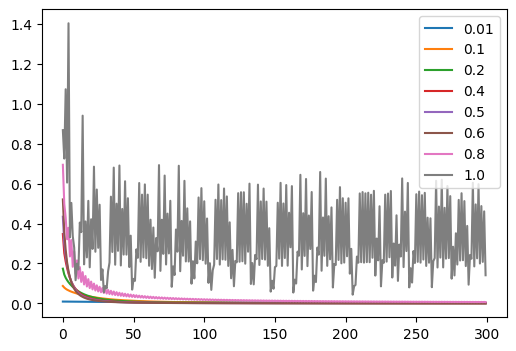

In [63]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores, learning_rates):
    ax.plot(scores, label=label)

ax.legend()

fig.show()

It doesn't make too much sense to compare target scores with different learning rates.

### Separate Learning rates

In [64]:
learning_rates = [0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

In [65]:
unitarity_scores = list()
overlap_scores = list()
target_scores = list()
matrix_dim = 2**6
target = np.sqrt(2)

num_iterations = 150

In [66]:
reduced_density_matrix = grouped_t
matrix = get_random_unitary_operator(grouped_t, matrix_dim)

In [67]:
for unitarity_lr in learning_rates:
    unitarity_scores.append(list())
    overlap_scores.append(list())
    target_scores.append(list())

    for overlap_lr in learning_rates:
        unitarity_scores[-1].append(list())
        overlap_scores[-1].append(list())
        target_scores[-1].append(list())

        current_matrix = matrix.copy()
    
        for _ in range(num_iterations):
            update(
                current_matrix,
                reduced_density_matrix,
                unitarity_scores[-1][-1],
                overlap_scores[-1][-1],
                target_scores[-1][-1],
                grouped_physical_leg_label,
                grouped_physical_leg_conj_label,
                matrix_dim,
                unitarity_lr=unitarity_lr,
                overlap_lr=overlap_lr,
                target=target
            )

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/3438622814.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


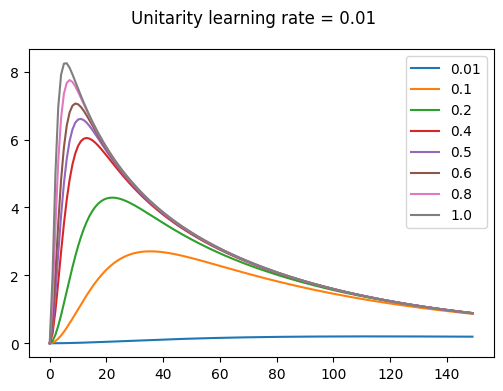

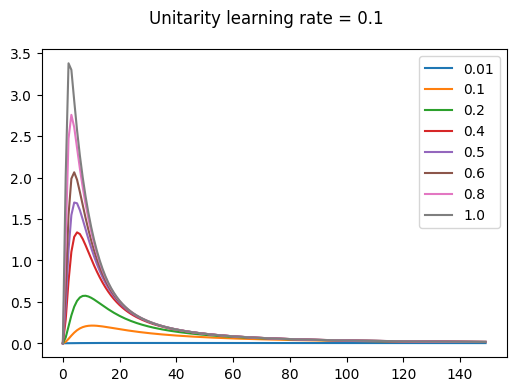

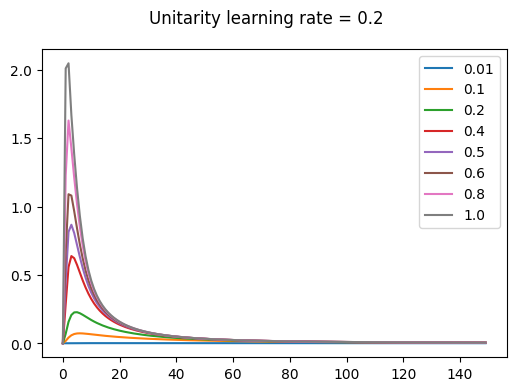

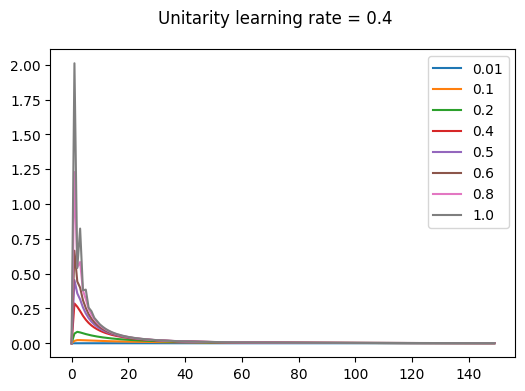

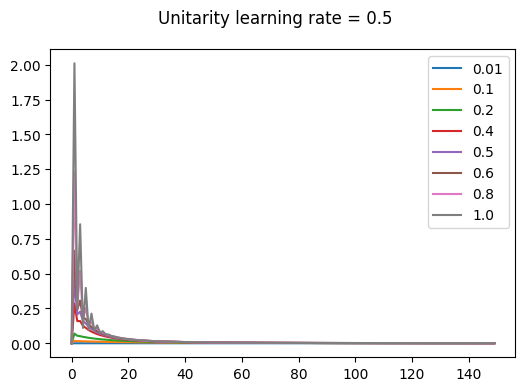

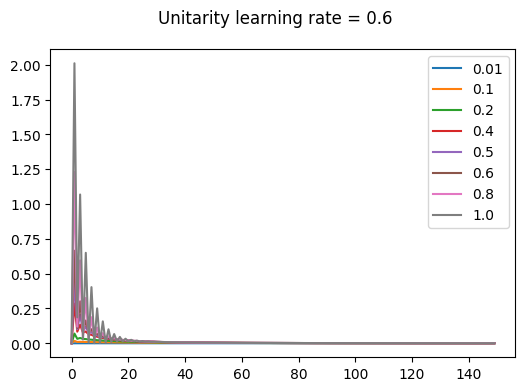

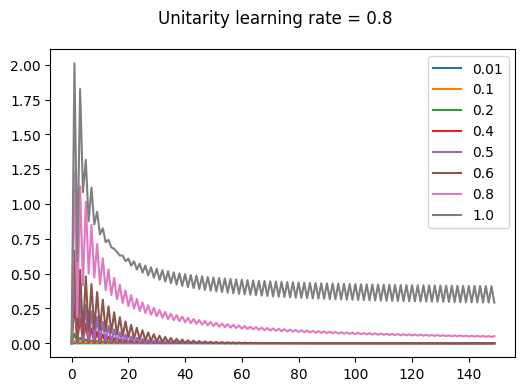

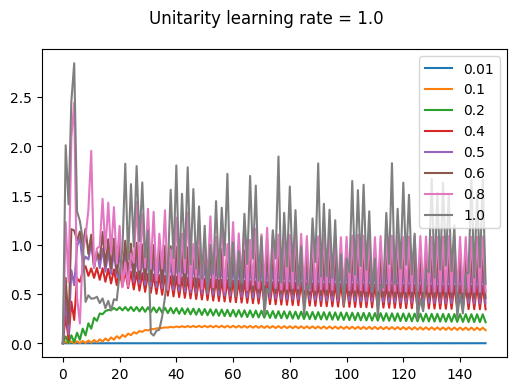

In [68]:
for scores_1, unitary_lr in zip(unitarity_scores, learning_rates):
    fig, ax = plt.subplots(figsize=(6, 4))

    for scores, overlap_lr in zip(scores_1, learning_rates):
        ax.plot(scores, label=overlap_lr)

    ax.legend()

    fig.suptitle(f"Unitarity learning rate = {unitary_lr}")
    fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/1248678868.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


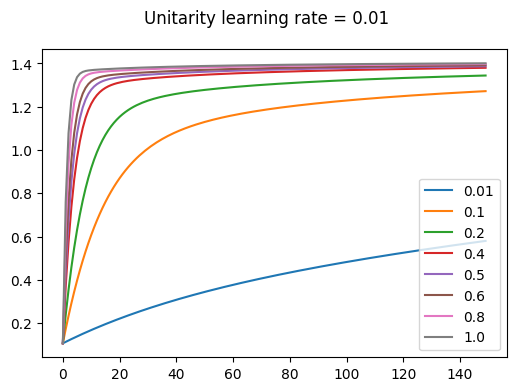

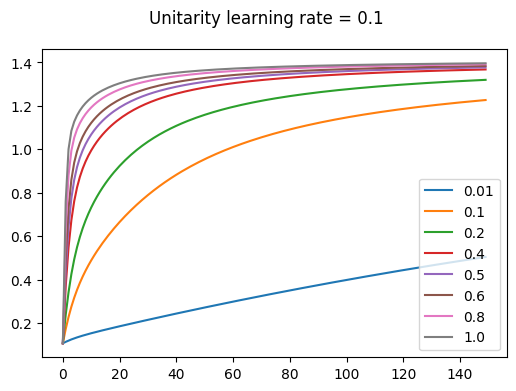

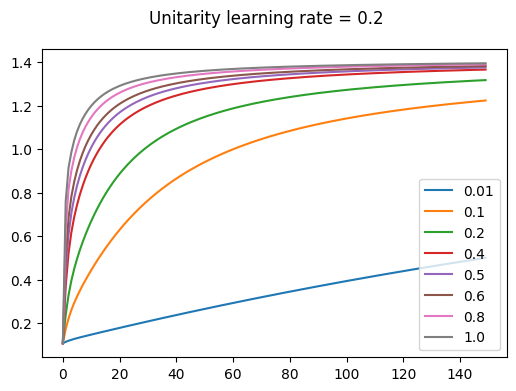

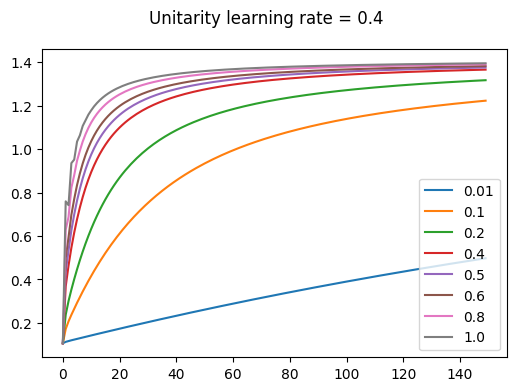

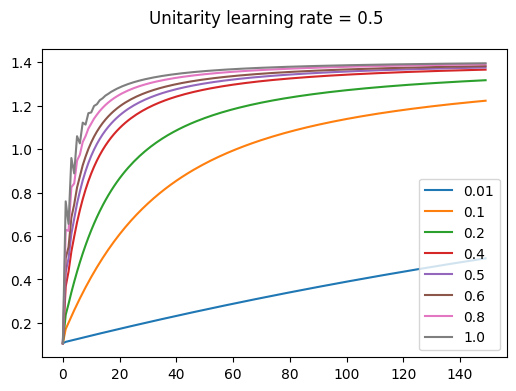

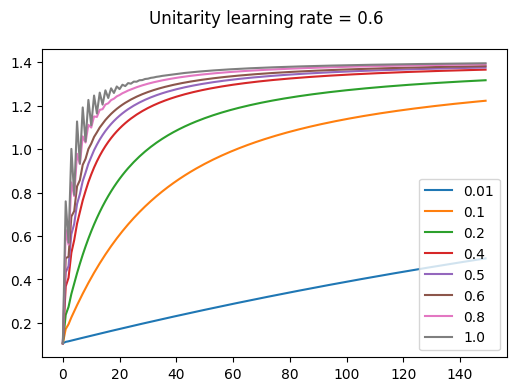

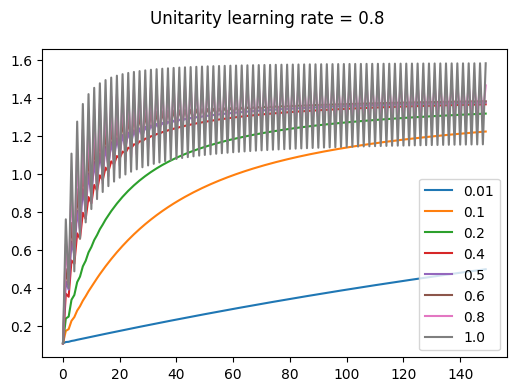

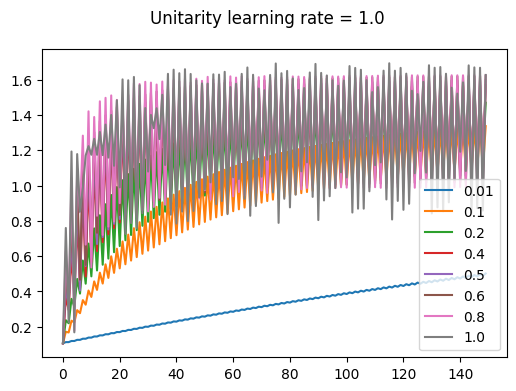

In [69]:
for scores_1, unitary_lr in zip(overlap_scores, learning_rates):
    fig, ax = plt.subplots(figsize=(6, 4))

    for scores, overlap_lr in zip(scores_1, learning_rates):
        ax.plot(scores, label=overlap_lr)

    ax.legend()

    fig.suptitle(f"Unitarity learning rate = {unitary_lr}")
    fig.show()

In [70]:
np.round(np.array(overlap_scores)[:,:, -1], 3)

array([[0.58 , 1.272, 1.344, 1.38 , 1.387, 1.391, 1.397, 1.401],
       [0.504, 1.227, 1.32 , 1.367, 1.377, 1.383, 1.391, 1.396],
       [0.5  , 1.224, 1.318, 1.366, 1.376, 1.382, 1.39 , 1.395],
       [0.498, 1.223, 1.317, 1.366, 1.375, 1.382, 1.39 , 1.395],
       [0.497, 1.222, 1.317, 1.365, 1.375, 1.382, 1.39 , 1.395],
       [0.497, 1.222, 1.317, 1.365, 1.375, 1.382, 1.39 , 1.395],
       [0.497, 1.222, 1.316, 1.365, 1.375, 1.382, 1.465, 1.582],
       [0.502, 1.336, 1.469, 1.569, 1.597, 1.619, 1.625, 1.626]])

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/3871090097.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


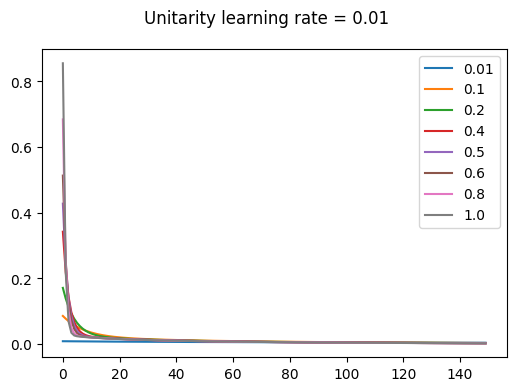

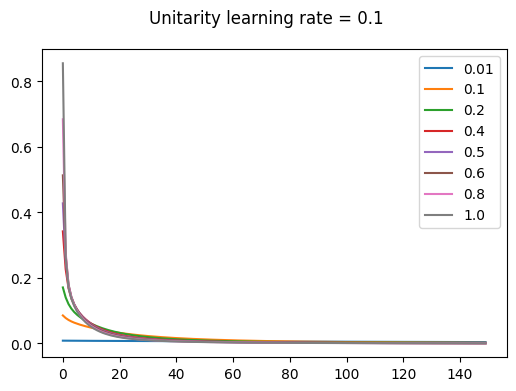

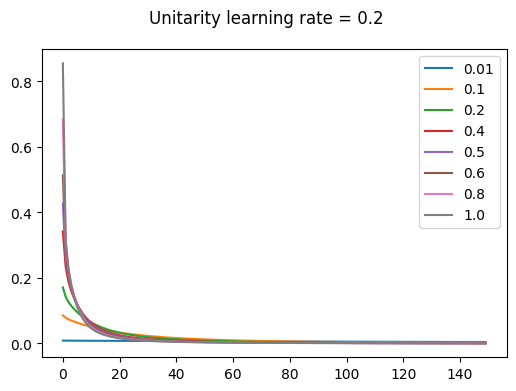

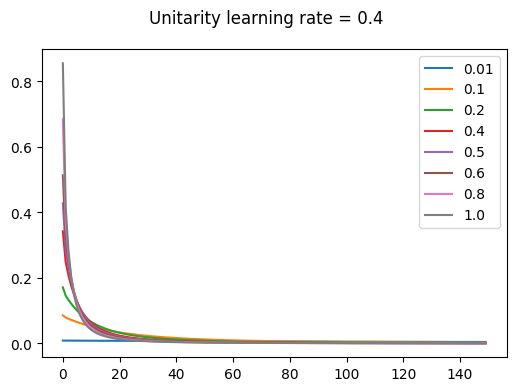

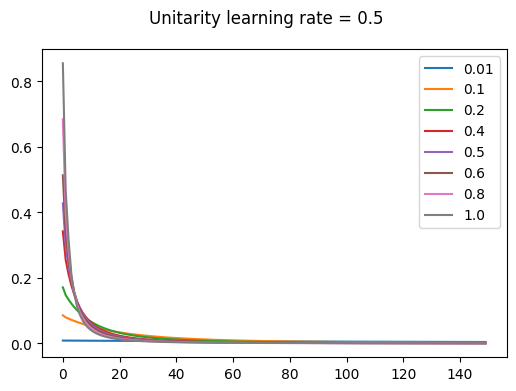

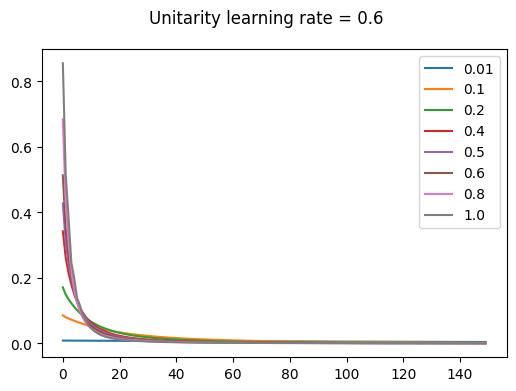

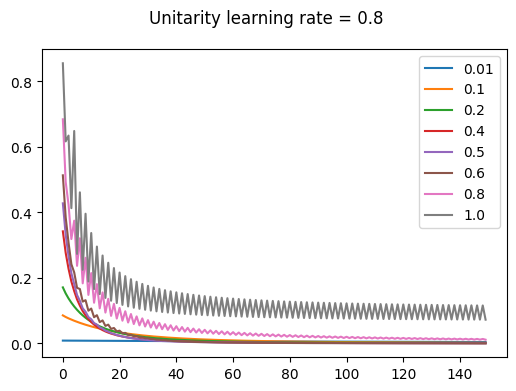

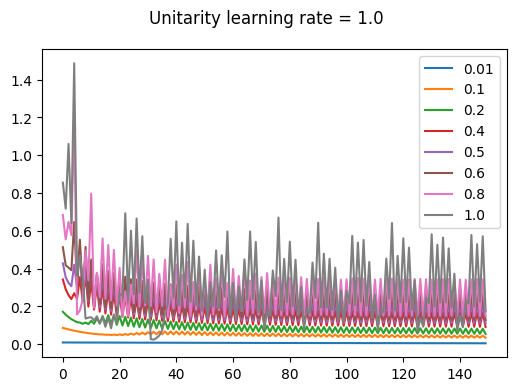

In [71]:
for scores_1, unitary_lr in zip(target_scores, learning_rates):
    fig, ax = plt.subplots(figsize=(6, 4))

    for scores, overlap_lr in zip(scores_1, learning_rates):
        ax.plot(scores, label=overlap_lr)

    ax.legend()

    fig.suptitle(f"Unitarity learning rate = {unitary_lr}")
    fig.show()

In [72]:
np.round(np.array(target_scores)[:,:, -1], 4)

array([[0.004 , 0.0032, 0.0027, 0.0025, 0.0024, 0.0024, 0.0023, 0.0023],
       [0.0042, 0.0021, 0.0013, 0.0008, 0.0008, 0.0007, 0.0006, 0.0006],
       [0.0042, 0.002 , 0.0011, 0.0007, 0.0006, 0.0005, 0.0004, 0.0004],
       [0.0042, 0.0019, 0.0011, 0.0006, 0.0005, 0.0004, 0.0004, 0.0003],
       [0.0042, 0.0019, 0.001 , 0.0006, 0.0005, 0.0004, 0.0003, 0.0003],
       [0.0042, 0.0019, 0.001 , 0.0006, 0.0005, 0.0004, 0.0003, 0.0003],
       [0.0042, 0.0019, 0.001 , 0.0005, 0.0004, 0.0004, 0.0113, 0.0724],
       [0.0043, 0.0336, 0.0538, 0.091 , 0.1092, 0.1275, 0.1481, 0.1735]])

In [73]:
good_index_pairs = [
    (i,j)
    for i, l in enumerate(np.array(target_scores)[:,:, -1])
    for j, v in enumerate(l)
    if v <= 0.0005
]

In [74]:
len(good_index_pairs)

16

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/2342308908.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


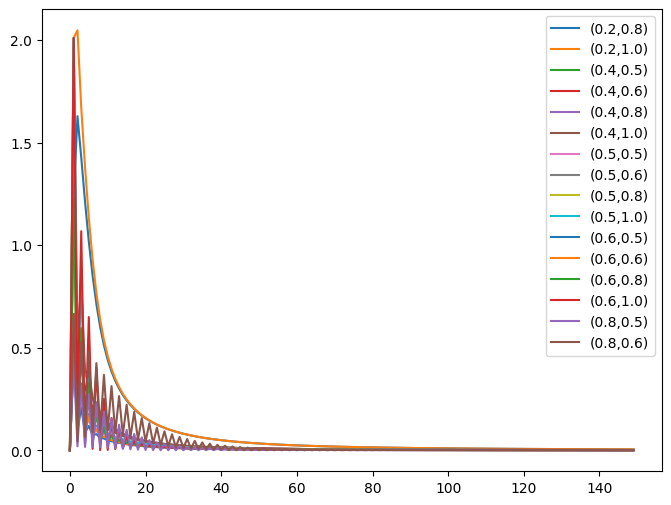

In [75]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, j in good_index_pairs:
    unitarity_lr = learning_rates[i]
    overlap_lr = learning_rates[j]

    ax.plot(unitarity_scores[i][j], label=f'({unitarity_lr},{overlap_lr})')

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/3718415151.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


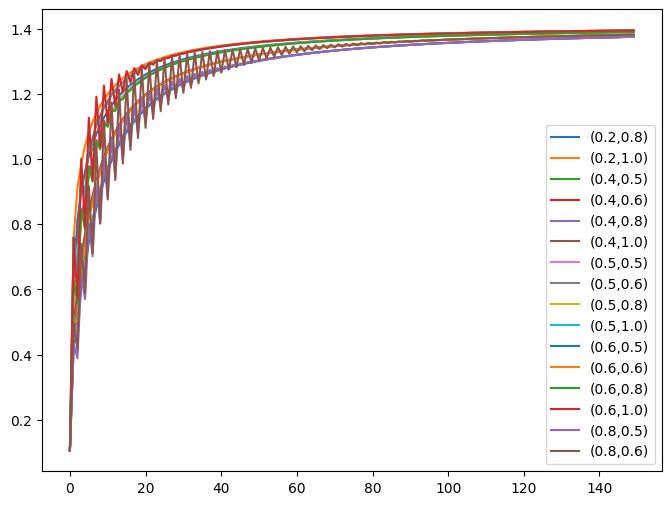

In [76]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, j in good_index_pairs:
    unitarity_lr = learning_rates[i]
    overlap_lr = learning_rates[j]

    ax.plot(overlap_scores[i][j], label=f'({unitarity_lr},{overlap_lr})')

ax.legend()

fig.show()

Looks like both learning rates around 0.5 are doing well. There's a wide range of comparable learning rates though.

## Random initialization

In [77]:
unitarity_scores = list()
overlap_scores = list()
target_scores = list()
matrix_dim = 2**6
target = np.sqrt(2)

num_iterations = 150
num_random_initializations = 100

In [78]:
lr = 0.4

In [79]:
matrix = get_random_unitary_operator(grouped_t, matrix_dim)

In [80]:
for _ in range(num_random_initializations):
    unitarity_scores.append(list())
    overlap_scores.append(list())
    target_scores.append(list())

    current_matrix = get_random_unitary_operator(grouped_t, matrix_dim)

    for _ in range(num_iterations):
        update(
            current_matrix,
            reduced_density_matrix,
            unitarity_scores[-1],
            overlap_scores[-1],
            target_scores[-1],
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label,
            matrix_dim,
            unitarity_lr=lr,
            overlap_lr=lr,
            target=target
        )

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/330050288.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


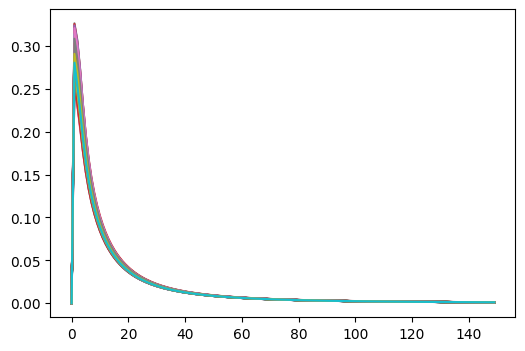

In [81]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores in unitarity_scores:
    ax.plot(scores)

fig.show()

In [82]:
pd.Series(np.array(unitarity_scores)[:,-1]).describe()

count    100.000000
mean       0.001144
std        0.000014
min        0.001109
25%        0.001134
50%        0.001144
75%        0.001152
max        0.001194
dtype: float64

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/1180909888.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


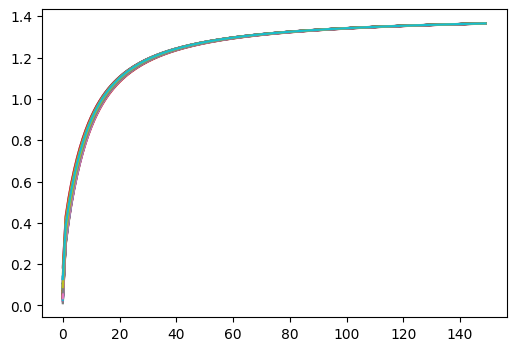

In [83]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores in overlap_scores:
    ax.plot(scores)

fig.show()

In [84]:
pd.Series(np.array(overlap_scores)[:,-1]).describe()

count    100.000000
mean       1.365327
std        0.000301
min        1.364263
25%        1.365152
50%        1.365335
75%        1.365542
max        1.366090
dtype: float64

In [85]:
pd.Series(np.array(overlap_scores)[:,0]).describe()

count    100.000000
mean       0.073362
std        0.038337
min        0.010392
25%        0.044994
50%        0.067216
75%        0.095508
max        0.192707
dtype: float64

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/3668244383.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


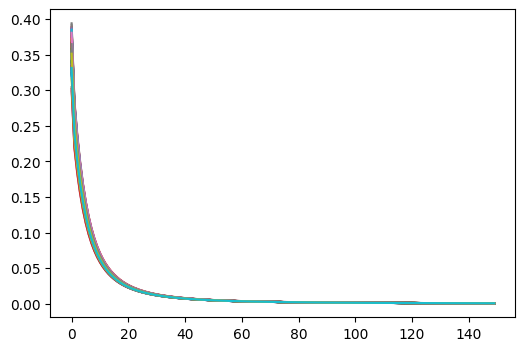

In [86]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores in target_scores:
    ax.plot(scores)

fig.show()

In this case, random initialization makes virtually no difference. Acutally surprising how uniform it is! This would likely change if the initial guess was not unitary.

## Differing numbers of sites

In [90]:
num_sites_values = [2, 4, 6, 7, 8]

In [91]:
unitarity_scores = list()
overlap_scores = list()
target_scores = list()
#matrix_dim = 2**6
target = np.sqrt(2)

lr = 0.4
num_iterations = 300

In [92]:
for n in num_sites_values:
    unitarity_scores.append(list())
    overlap_scores.append(list())
    target_scores.append(list())

    current_bs = [
        test_case.psi.get_B(i)
        for i in range(
            test_case.right_symmetry_index + 1,
            test_case.right_symmetry_index + 1 + n
        )
    ]

    t = left_environment
    
    for i, b in enumerate(current_bs):
        b_current = b.replace_label('p', f'p{i}')
    
        t = npc.tensordot(t, b_current, [['vR'], ['vL']])
        t = npc.tensordot(t, b_current.conj(), [['vR*'], ['vL*']])
    
    t = npc.trace(t, 'vR', 'vR*')

    leg_labels = [f'p{i}' for i in range(n)]
    leg_conj_labels = [f'p{i}*' for i in range(n)]

    current_grouped_t = t.combine_legs([leg_labels, leg_conj_labels])

    grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
    grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

    matrix_dim = 2**n
    current_matrix = get_random_unitary_operator(current_grouped_t, matrix_dim)

    for _ in range(num_iterations):
        update(
            current_matrix,
            current_grouped_t,
            unitarity_scores[-1],
            overlap_scores[-1],
            target_scores[-1],
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label,
            matrix_dim,
            unitarity_lr=lr,
            overlap_lr=lr,
            target=target
        )

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/3649752980.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


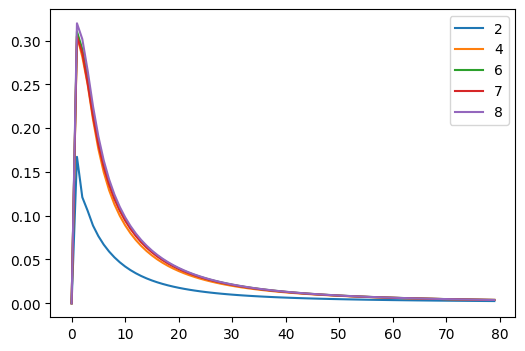

In [94]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores, num_sites_values):
    ax.plot(scores[:80], label=label)

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/285502174.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


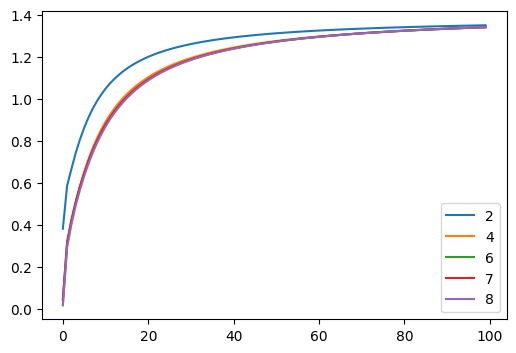

In [96]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(overlap_scores, num_sites_values):
    ax.plot(scores[:100], label=label)

ax.legend()

fig.show()

In [97]:
np.array(overlap_scores)[:,-1]

array([1.37231774, 1.38677177, 1.3893967 , 1.3894796 , 1.38980571])

Has a small impact on performance.

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60340/3945835743.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


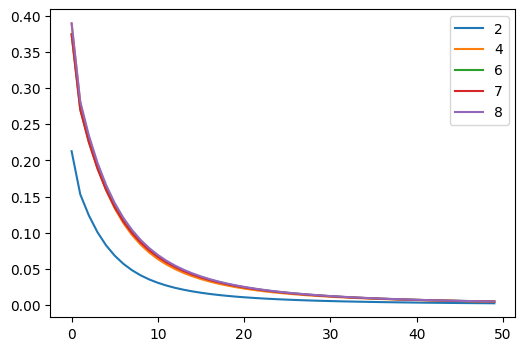

In [100]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores, num_sites_values):
    ax.plot(scores[:50], label=label)

ax.legend()

fig.show()

In [99]:
np.array(target_scores)[:,-1]

array([0.00043674, 0.00018744, 0.00015329, 0.00015223, 0.00014828])

As expected, slower convergence for more dimensions. But not much more slower! The main trade-off is the exponential increase in time complexity with dimension. Comparable cutoff to SVD approach.

To-do:
* Extract SPT phase, sweep over states (might be a separate notebook?)
    * Would need to account for symmetry transfer matrix singular value with sweep. May be better to just solve for left and right simultaneously?

# Conclusions

* Yeah, it works!
* Generally insensitive to learning rates with good convergence.
* Doesn't get stuck in local optima.
* Could still have an issue with unitarity costs for longer correlation lengths...? Not encountered here.
* Do need to specify the target overlap however.
* Performance insensitive to dimension, but exponential scaling results in effectively a hard cutoff of 8 sites.

# Old code

## Test on scalars

In [77]:
scalar = 2*1j

In [78]:
scalar_rdm = npc.Array.from_ndarray_trivial(np.array([[scalar]]), labels=['p', 'p*'])

In [79]:
scalar_rdm

<npc.Array shape=(1, 1) labels=['p', 'p*']>

In [80]:
scalar_matrix = npc.Array.from_ndarray_trivial(np.array([[1.5]]), labels=['p', 'p*'])

In [81]:
unitarity_scores = list()
overlap_scores = list()
target_scores = list()
target = np.abs(scalar)
matrix_dim = 1
scalar_matrix_values = [scalar_matrix[0,0],]

In [82]:
unitarity_lr = 0.01
overlap_lr = 0.01

In [83]:
update(
    scalar_matrix,
    scalar_rdm,
    unitarity_scores,
    overlap_scores,
    target_scores,
    'p',
    'p*',
    matrix_dim,
    unitarity_lr=unitarity_lr,
    overlap_lr=overlap_lr,
    target=target
)

scalar_matrix_values.append(np.abs(scalar_matrix[0,0]))

In [84]:
unitarity_scores

[1.5625]

In [85]:
overlap_scores

[3.0]

In [86]:
for _ in range(100):
    update(
        scalar_matrix,
        scalar_rdm,
        unitarity_scores,
        overlap_scores,
        target_scores,
        'p',
        'p*',
        matrix_dim,
        unitarity_lr=unitarity_lr,
        overlap_lr=overlap_lr,
        target=target
    )

    scalar_matrix_values.append(np.abs(scalar_matrix[0,0]))

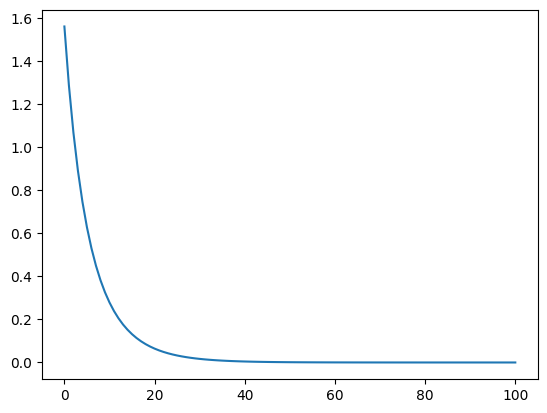

In [87]:
plt.plot(unitarity_scores)

In [88]:
unitarity_scores[-1]

2.5438619757345293e-06

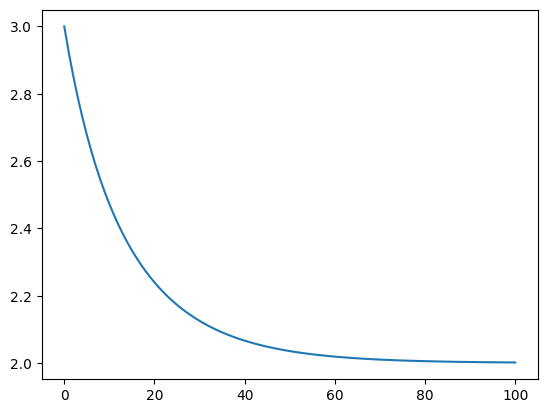

In [89]:
plt.plot(overlap_scores)

In [90]:
overlap_scores[-1]

2.001594313435545

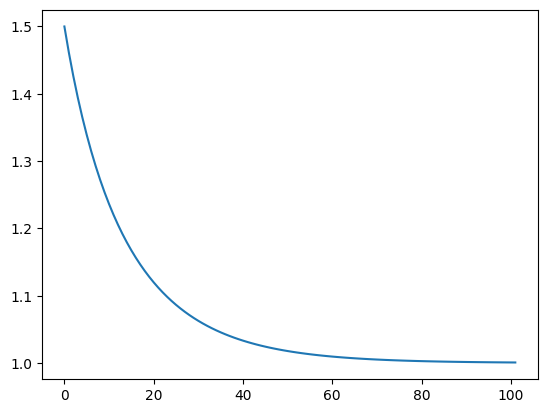

In [91]:
plt.plot(scalar_matrix_values)

In [92]:
scalar_matrix.to_ndarray()

array([[1.00074931+0.j]])

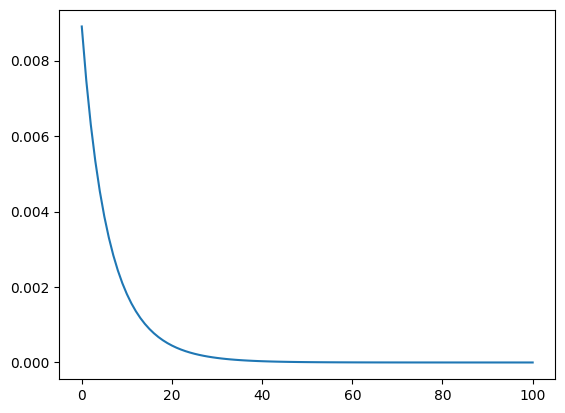

In [93]:
plt.plot(target_scores)